In [221]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install tensorflow
!pip install seaborn

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits


In [80]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns


In [81]:
## Aux functions
def partitioning(datos,size_S,size_T):
    """ 
        Método que hace el partitioning de los datos en el set de S, training, testing y validation
        Recibe:
            1. datos: Datos al cual se le va a hacer el partitioning
            2. Size_S: Tamaño del set S
            3. Size_T: Tamaño del set T (training)
        Entrega:
            1. S: Set S
            2. V: set de validación V
            3. T: set de training T
            4. t: set de testing t
    """
    indices_datos = np.arange(len(datos))

    indices_S = np.random.choice(indices_datos, size=int(round(len(datos)*size_S)),replace=False)
    indices_V = np.setdiff1d(indices_datos, indices_S)
    indices_T = np.random.choice(indices_S, size=int(round(len(datos)*size_T)),replace=False)
    indices_t = np.setdiff1d(indices_S, indices_T)

    S= datos[indices_S]
    
    V= datos[np.random.choice(indices_V, size=len(indices_V),replace=False)]
    T= datos[indices_T]
    t= datos[np.random.choice(indices_t, size=len(indices_t),replace=False)]

    return S,V,T,t
def normalize_min_max(matrix):
    """
        Método para normalizar los datos
        Recibe: 
            1. matrix: Matriz de datos original
        Entrega: 
            1. Matriz de datos normalizados
    """
    max_values = np.max(matrix, axis=0)
    min_values = np.min(matrix, axis=0)

    # Lleva los datos al hiperplano (0, 1) utilizando la normalización min-max
    normalized_data = (matrix - min_values) / (max_values - min_values)
    return normalized_data

In [33]:
class MLP:
    def __init__(self, neurons_per_capa, activation_functions) -> None:
        self.n = neurons_per_capa[0]
        self.neurons_per_capa = neurons_per_capa
        self.activation_functions = activation_functions
        self.neurons_ampliado = [neurons_per_capa[0]] + neurons_per_capa
        self.pesos = [
            np.random.rand(self.neurons_ampliado[i+1],self.neurons_ampliado[i]) for i in range(len(self.neurons_ampliado)-1)
        ]

    def activationFunctions(self,v,funcion,a=1.2,b=0,c=0.85,d=0.8):
        if funcion=="lineal": return (a*v+b), a*np.ones(v.shape)
        elif funcion=="tanh": return np.tanh(c*v), c*(1-np.tanh(c*v)**2)
        elif funcion =="sigmoid": return 1/(1+np.exp(-d*v)), d*np.exp(-d*v)/((1+np.exp(-d*v))**2)
        else: raise ValueError("Función de activación no válida")

    def forward(self,entradas,pesos=None, activation_functions=None):
        if not pesos:
            pesos = self.pesos
        if not activation_functions:
            activation_functions = self.activation_functions
        
        phis, phis_primes = [0]*len(self.neurons_ampliado), [0]*len(self.neurons_per_capa)
        phis[0] = entradas

        for i in range(1,len(phis)):
            phi, phi_prime =  self.activationFunctions(np.dot(self.pesos[i-1], phis[i-1]), activation_functions[i-1])
            phis[i], phis_primes[i-1] = phi, phi_prime
        return phis, phis_primes

    
    def backpropagation(self,phis, phis_prime,error, learning_rate):

        deltas = [np.zeros(i) for i in self.neurons_per_capa]
        delta_j = error*phis_prime[-1]
        deltas[-1][:] = [i[0] for i in delta_j]

        self.pesos[-1] += learning_rate*np.dot(delta_j,phis[-2].T)

        for i in range(1,len(self.neurons_per_capa)):
            delta_j = np.multiply(phis_prime[-(i+1)], np.dot(self.pesos[-i].T,delta_j) )
            deltas[-(i+1)][:] = [j[0] for j in delta_j]
            self.pesos[-(i+1)] += learning_rate*np.dot(delta_j, phis[-(i+2)].T)

        return self.pesos, deltas

    def calculate_loss(self, out, yd):
        return (1/2)*np.sum((yd - out)**2)

    def prueba(self,datos,learning_rate, n_epochs):
        _,V,train,test = partitioning(datos,0.8,0.6)
        # data_x = train[:,:-1]
        # data_y = train[:,[-1]]

        data_x = train
        data_y = train

        deltas_epochs = []
        e_training_epocs,e_testing_epochs = np.zeros(n_epochs), np.zeros(n_epochs)
        for epoch in range(n_epochs):
            deltas_epoch = [np.zeros((i,data_x.shape[0])) for i in self.neurons_per_capa]
            e_training = np.zeros(len(data_x))
            for i in range(len(data_x)):
                entradas = np.array([[i] for i in data_x[i]])
                phis, phis_primes = self.forward(entradas)
                self.pesos,deltas = self.backpropagation(phis,phis_primes,(np.sum(data_y[i]-phis[-1])),learning_rate)
                for j in range(len(self.neurons_per_capa)):
                    deltas_epoch[j][:,i] = deltas[j]
                e_training[i] = self.calculate_loss(phis[-1], data_y[i])
            e_training_epocs[epoch] = np.mean(e_training)
            deltas_epochs.append(deltas_epoch)

            # data_x = test[:,:-1]
            # data_y = test[:,[-1]]
            data_x = test
            data_y = test
            errores = [0]*len(data_x)
            phissss= [0]*len(data_x)
            e_testing = np.zeros(len(data_x))
            for i in range(len(data_x)):
                entradas = np.array([[i] for i in data_x[i]])
                phis, phis_primes = self.forward(entradas)
                errores[i] = data_y[i]-phis[-1]
                phissss[i] = phis[-1]
                e_testing[i] = self.calculate_loss(phis[-1], data_y[i])
            e_testing_epochs[epoch] = np.mean(e_testing)

        # data_x = V[:,:-1]
        # data_y = V[:,[-1]]
        data_x = V
        data_y = V
        errores = [0]*len(data_x)
        phissss= [0]*len(data_x)
        e_validation = np.zeros(len(data_x))
        for i in range(len(data_x)):
            entradas = np.array([[i] for i in data_x[i]])
            phis, phis_primes = self.forward(entradas)
            errores[i] = data_y[i]-phis[-1]
            phissss[i] = phis[-1]
            e_validation[i] = self.calculate_loss(phis[-1], data_y[i])
        return errores, data_y, phissss,data_x, self.pesos, deltas_epochs, e_training_epocs, e_testing_epochs, np.mean(e_validation),V,train,test

In [82]:
data = loadmat('datos.mat')
# data_combined = np.concatenate((data['X'], data['OD'], data['S']), axis=1)
data_combined = np.concatenate((data['t'],data['COD1'], data['Xv1']), axis=1)
normalized_data = normalize_min_max(data_combined)

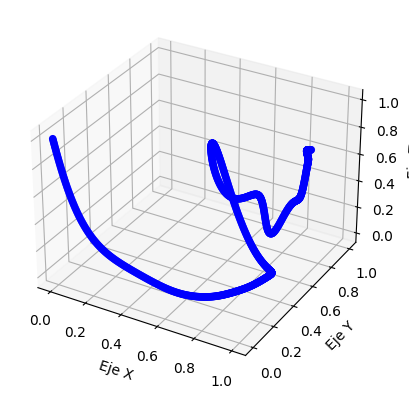

In [83]:
## View data
# Crear una figura 3D
fig = plt.figure()

# Agregar un subplot 3D
ax = fig.add_subplot(111, projection='3d')

# Crear un gráfico de dispersión en 3D
ax.scatter(normalized_data[:,2],normalized_data[:,0],normalized_data[:,1], c='blue')

# Etiquetas de los ejes
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Mostrar el gráfico
plt.show()

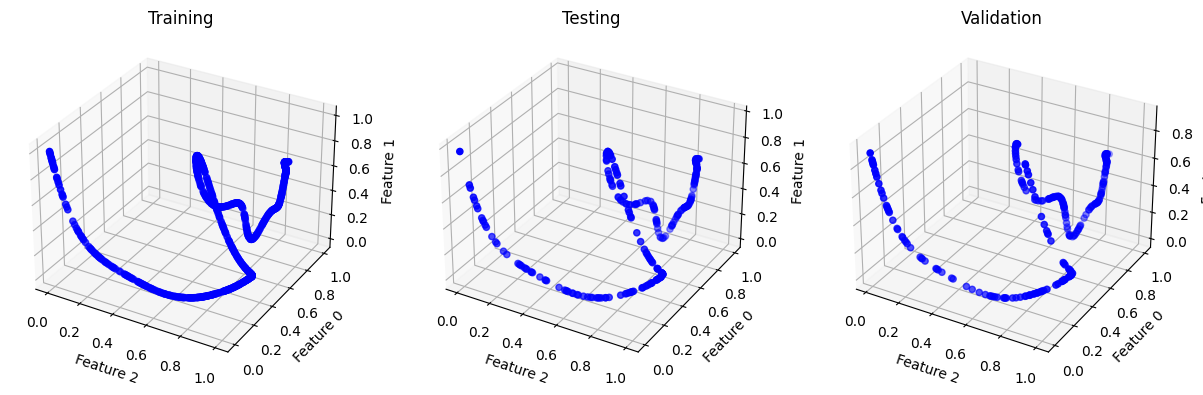

In [84]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), subplot_kw={'projection': '3d'})
S, V, T, t = partitioning(normalized_data, 0.8, 0.6)
sets = [T, t, V]
sets_titles = ["Training", "Testing", 'Validation']

for i in range(len(sets)):
    axes[i].scatter(sets[i][:, 2], sets[i][:, 0], sets[i][:, 1], c='blue')
    axes[i].set_title(sets_titles[i])
    axes[i].set_xlabel('Feature 2')
    axes[i].set_ylabel('Feature 0')
    axes[i].set_zlabel('Feature 1')
plt.show()

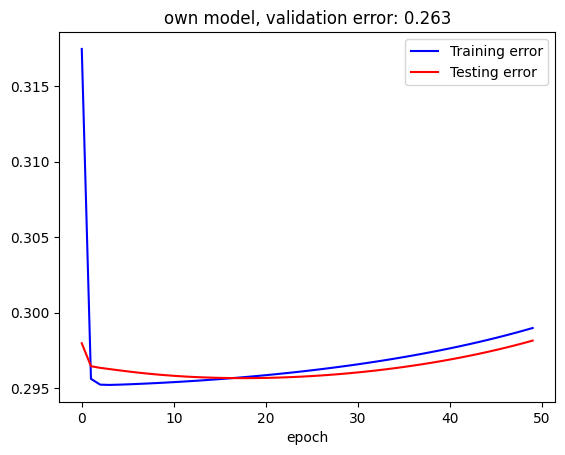

In [213]:
instance = MLP([3,5,3],["lineal",'lineal',"sigmoid"])
errores, data_y, phissss,data_x, pesos, deltas_epochs, e_training_epocs, e_testing_epochs, e_validation,V,train,test = instance.prueba(normalized_data,0.01,50)
out = np.array(phissss).reshape(data_x.shape)
plt.plot(e_training_epocs, label='Training error', color='blue')
plt.plot(e_testing_epochs, label='Testing error', color='r')
plt.title(f'own model, validation error: {round(e_validation,3)}')
plt.xlabel('epoch')
plt.legend()

In [86]:
def calculate_error_model(yd,out):
    sum = 0
    for i in range(len(yd)):
        sum+=(1/2)*np.sum((yd[i] - out[i])**2)
    return sum/len(yd)

In [214]:
# MLP con 2 neuronas en la capa de entrada, 16 neuronas en la capa oculta y 1 neurona en la capa de salida
model = Sequential([
    Dense(3, activation='linear', input_shape=(3,)),
    Dense(5, activation='linear',use_bias=False),
    Dense(3, activation='sigmoid')
])

# Compila el modelo
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

# Entrena el modelo
n_epochs = 50
loss_train= []
loss, accuracy = np.zeros(n_epochs),np.zeros(n_epochs)
for i in range(n_epochs):
    training_y = model.predict(train)
    model.fit(train, train, epochs=1)
    loss_train.append(calculate_error_model(train,training_y))
    # Evalúa el modelo
    # loss[i], accuracy[i] = model.evaluate(test, test)
    testing_y = model.predict(test)
    loss[i] = calculate_error_model(test,testing_y)

y_pred_model = model.predict(V)

8/8 [==============================] - 0s 1ms/step


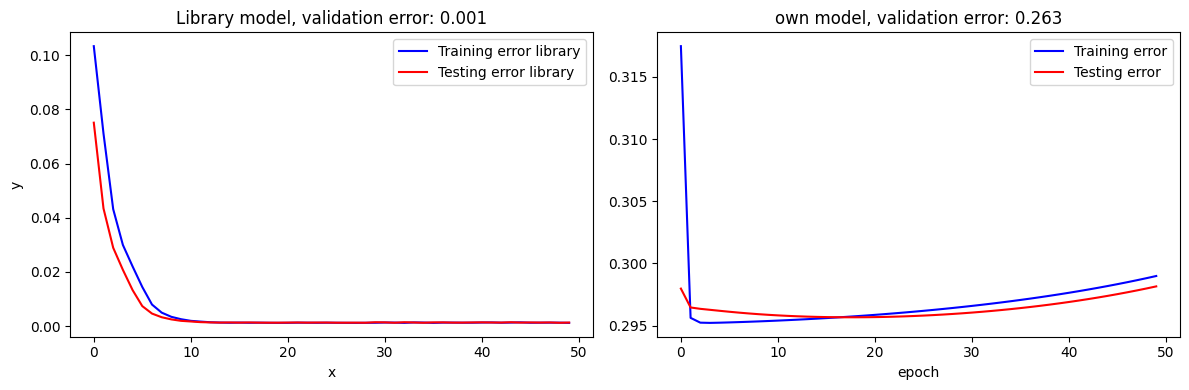

In [215]:
import matplotlib.pyplot as plt
import numpy as np

# Crear un subplot de 1 fila y 2 columnas
plt.figure(figsize=(12, 4))  # Ajusta el tamaño de la figura (ancho, alto)

# Primer gráfico (izquierda)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(loss_train, label='Training error library', color='blue')
plt.plot(loss, label='Testing error library', color='r')
plt.title(f'Library model, validation error: {round(calculate_error_model(y_pred_model,V),3)}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Segundo gráfico (derecha)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(e_training_epocs, label='Training error', color='blue')
plt.plot(e_testing_epochs, label='Testing error', color='r')
plt.title(f'own model, validation error: {round(e_validation,3)}')
plt.xlabel('epoch')
plt.legend()

plt.tight_layout()  # Ajusta automáticamente el espacio entre los gráficos
plt.show()


In [216]:
np.mean(loss_train),np.mean(loss), np.mean(e_training_epocs), np.mean(e_testing_epochs)

(0.007072437628489425,
 0.0050671683823891945,
 0.29692294191012536,
 0.29634661332858203)

/var/folders/y5/31btzt894y11q5v12srqshw80000gn/T/ipykernel_97072/1020623459.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(V[:, cont], ax=ax, label='Real data', shade=True)
/var/folders/y5/31btzt894y11q5v12srqshw80000gn/T/ipykernel_97072/1020623459.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(out[:, cont], ax=ax, label='Own model', shade=True)
/var/folders/y5/31btzt894y11q5v12srqshw80000gn/T/ipykernel_97072/1020623459.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(V[:, cont], ax=ax, label='Real data', shade=True)
/var/folders/y5/31btzt894y11q5v12srqshw80000gn/T/ipykernel_97072/1020623459.py:14: Future

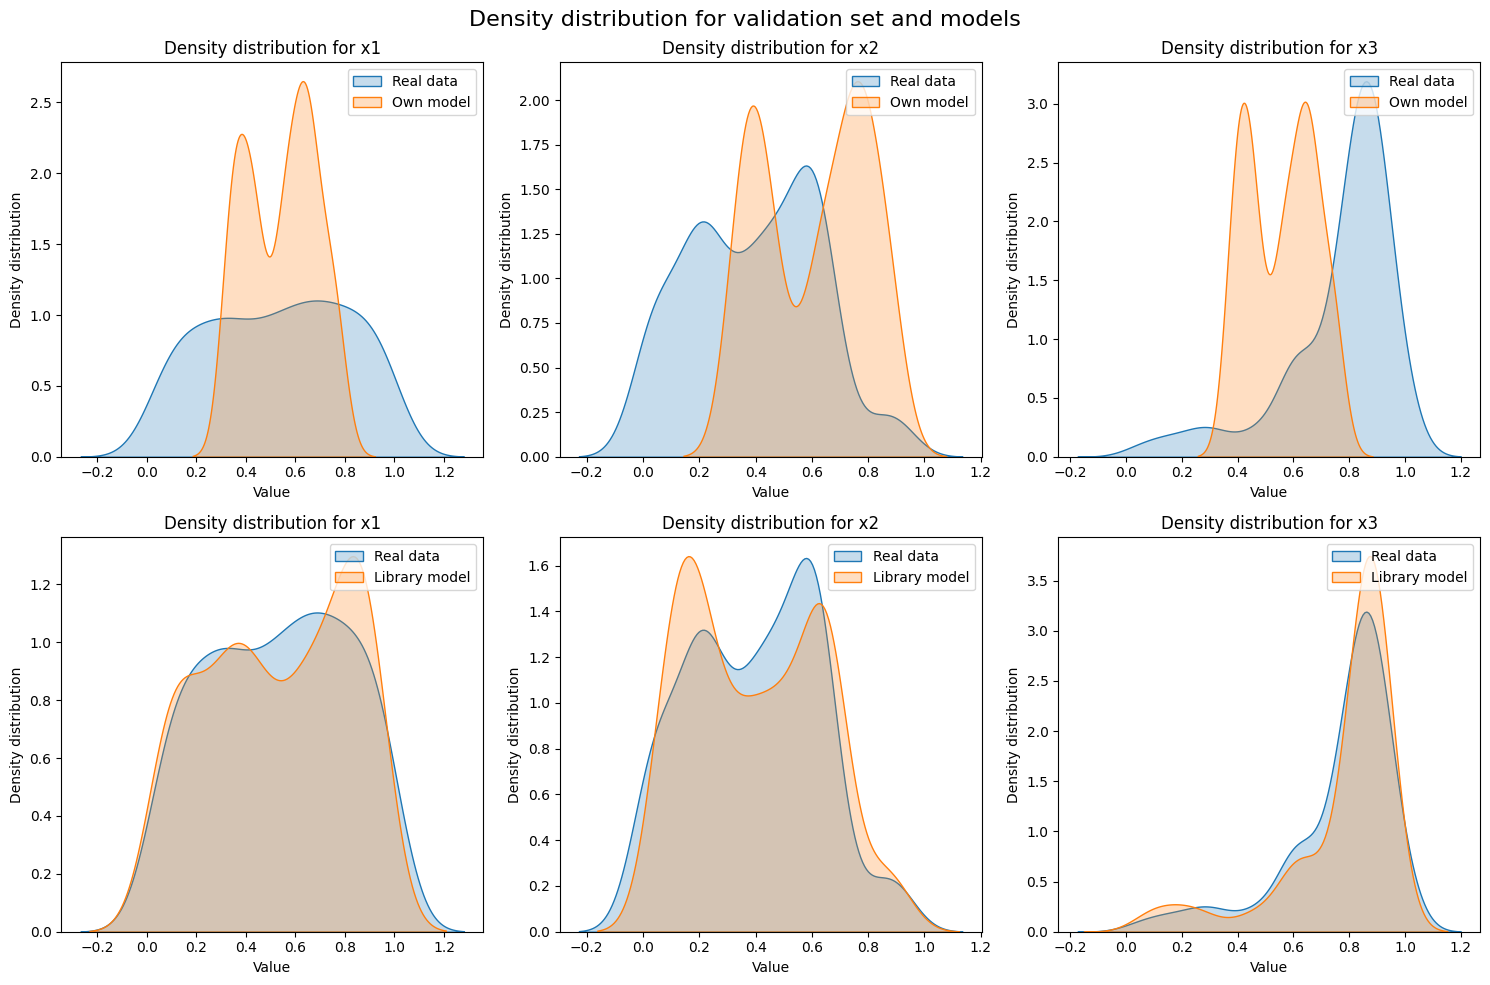

In [217]:
# Crea una figura con 6 subplots en 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Density distribution for validation set and models', fontsize=16)

# Añade un título a cada subplot
titles = ['Density distribution for x1', 'Density distribution for x2', 'Density distribution for x3', 'Density distribution for x1', 'Density distribution for x2', 'Density distribution for x3']

# Itera sobre los subplots y los datos correspondientes
cont = 0
for i, ax in enumerate(axes.flatten()):
    # Utiliza Seaborn para trazar la densidad de distribución de data1 en los subplots impares
    if i <3:
        sns.kdeplot(V[:, cont], ax=ax, label='Real data', shade=True)
        sns.kdeplot(out[:, cont], ax=ax, label='Own model', shade=True)
        cont+=1
    # Utiliza Seaborn para trazar la densidad de distribución de data2 en los subplots pares
    else:
        if cont>2:
            cont=0
        sns.kdeplot(V[:, cont], ax=ax, label='Real data', shade=True)
        sns.kdeplot(y_pred_model[:, cont], ax=ax, label='Library model', shade=True)
        cont+=1
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Density distribution')
    ax.set_title(titles[i])
    ax.legend()

# Ajusta el espaciado entre los subplots
plt.tight_layout()

# Muestra la figura con los subplots
plt.show()

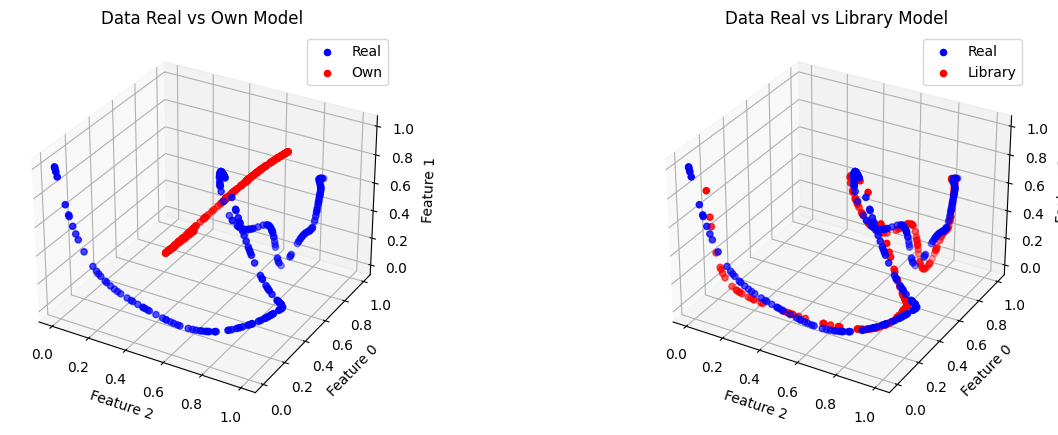

In [220]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), subplot_kw={'projection': '3d'})
S, V, T, t = partitioning(normalized_data, 0.8, 0.6)
sets = [T, t, V]
sets_titles = ["Training", "Testing", 'Validation']

axes[0].scatter(V[:, 2], V[:, 0], V[:, 1], c='blue', label='Real')
axes[0].scatter(out[:, 2], out[:, 0], out[:, 1], c='r',label="Own")
axes[0].set_title("Data Real vs Own Model")
axes[0].set_xlabel('Feature 2')
axes[0].set_ylabel('Feature 0')
axes[0].set_zlabel('Feature 1')
axes[0].legend()

axes[1].scatter(V[:, 2], V[:, 0], V[:, 1], c='blue',label='Real')
axes[1].scatter(y_pred_model[:, 2], y_pred_model[:, 0], y_pred_model[:, 1], c='r',label='Library')
axes[1].set_title("Data Real vs Library Model")
axes[1].set_xlabel('Feature 2')
axes[1].set_ylabel('Feature 0')
axes[1].set_zlabel('Feature 1')
axes[1].legend()

# plt.legend()
plt.show()
